In [2]:
# Check if GPU is enabled
import torch
print("Checking GPU...")

if torch.cuda.is_available():
    print(f"✓ GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠ WARNING: No GPU found!")
    print("\n👉 Fix this: Runtime → Change runtime type → T4 GPU")
    print("   Then: Runtime → Restart runtime")

Checking GPU...
✓ GPU detected: Tesla T4
  Memory: 15.8 GB


In [3]:
%%writefile trm_model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyRecursiveModel(nn.Module):
    def __init__(self, vocab_size=10, hidden_size=256, num_layers=2,
                 n_recursions=4, T_cycles=2, seq_len=81):
        super().__init__()
        self.n_recursions = n_recursions
        self.T_cycles = T_cycles

        self.input_embedding = nn.Embedding(vocab_size, hidden_size)
        self.y_init = nn.Parameter(torch.randn(1, seq_len, hidden_size) * 0.01)
        self.z_init = nn.Parameter(torch.randn(1, seq_len, hidden_size) * 0.01)

        # Simple network
        self.net = nn.Sequential(
            nn.Linear(hidden_size * 3, hidden_size * 4),
            nn.ReLU(),
            nn.Linear(hidden_size * 4, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        self.output_head = nn.Linear(hidden_size, vocab_size)
        self.q_head = nn.Linear(hidden_size, 1)

    def forward(self, x_input, y_true=None, n_supervision=8):
        B = x_input.size(0)
        device = x_input.device

        x = self.input_embedding(x_input)
        y = self.y_init.expand(B, -1, -1).to(device)
        z = self.z_init.expand(B, -1, -1).to(device)

        total_loss = 0.0
        steps = 0

        for step in range(n_supervision):
            # T-1 cycles without gradients
            with torch.no_grad():
                for _ in range(self.T_cycles - 1):
                    for _ in range(self.n_recursions):
                        combined = torch.cat([x, y, z], dim=-1)
                        z = self.net(combined)
                    combined = torch.cat([x, y, z], dim=-1)
                    y = self.net(combined)

            # Final cycle with gradients
            for _ in range(self.n_recursions):
                combined = torch.cat([x, y, z], dim=-1)
                z = self.net(combined)
            combined = torch.cat([x, y, z], dim=-1)
            y = self.net(combined)

            y_pred = self.output_head(y)
            q_pred = torch.sigmoid(self.q_head(y.mean(dim=1)))

            if y_true is not None:
                ce_loss = F.cross_entropy(
                    y_pred.reshape(-1, y_pred.size(-1)),
                    y_true.reshape(-1)
                )
                correct = (y_pred.argmax(dim=-1) == y_true).float().mean(dim=1, keepdim=True)
                halt_loss = F.binary_cross_entropy(q_pred, correct)

                total_loss += ce_loss + 0.5 * halt_loss
                steps += 1

                if q_pred.mean() > 0.5:
                    break

            y = y.detach()
            z = z.detach()

        if y_true is not None:
            return y_pred, {'total_loss': total_loss, 'steps': steps}
        return y_pred

Writing trm_model.py


In [4]:
# Check that file was created
import os
if os.path.exists('trm_model.py'):
    print("✓ TRM model file created successfully")
    from trm_model import TinyRecursiveModel
    print("✓ Model imported successfully")
else:
    print("✗ Error: File not created")

✓ TRM model file created successfully
✓ Model imported successfully


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

def create_toy_data(n_samples):
    """Create toy Sudoku-like data for testing"""
    puzzles = torch.randint(0, 10, (n_samples, 81))
    solutions = torch.randint(1, 10, (n_samples, 81))
    return TensorDataset(puzzles, solutions)

# Create datasets
print("Creating datasets...")
train_data = create_toy_data(500)
val_data = create_toy_data(100)
test_data = create_toy_data(200)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

print(f"✓ Data loaded")
print(f"  Train: {len(train_data)} samples")
print(f"  Val: {len(val_data)} samples")
print(f"  Test: {len(test_data)} samples")

Creating datasets...
✓ Data loaded
  Train: 500 samples
  Val: 100 samples
  Test: 200 samples


In [6]:
from tqdm import tqdm
import time

def train_experiment(config, train_loader, test_loader):
    """Train one experiment"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print(f"\n{'='*60}")
    print(f"Experiment: {config['name']}")
    print(f"  Layers: {config['num_layers']}")
    print(f"  Recursions (n): {config['n_recursions']}")
    print(f"  Cycles (T): {config['T_cycles']}")
    print(f"{'='*60}")

    # Create model
    model = TinyRecursiveModel(
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        n_recursions=config['n_recursions'],
        T_cycles=config['T_cycles']
    ).to(device)

    n_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {n_params/1e6:.2f}M")

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )

    # Training loop
    best_test_acc = 0
    start_time = time.time()
    history = {'train_acc': [], 'test_acc': [], 'epoch': []}

    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        total_correct = 0
        total_tokens = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred, losses = model(x, y, n_supervision=config['n_supervision'])
            losses['total_loss'].backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            pred_tokens = y_pred.argmax(dim=-1)
            total_correct += (pred_tokens == y).sum().item()
            total_tokens += y.numel()
            total_loss += losses['total_loss'].item()

        train_acc = total_correct / total_tokens

        # Evaluate
        if epoch % 20 == 0 or epoch == config['num_epochs'] - 1:
            model.eval()
            test_correct = 0
            test_tokens = 0

            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    y_pred = model(x, n_supervision=config['n_supervision'])
                    test_correct += (y_pred.argmax(dim=-1) == y).sum().item()
                    test_tokens += y.numel()

            test_acc = test_correct / test_tokens
            best_test_acc = max(best_test_acc, test_acc)

            history['epoch'].append(epoch)
            history['train_acc'].append(train_acc)
            history['test_acc'].append(test_acc)

            elapsed = time.time() - start_time
            print(f"Epoch {epoch:3d} | Train: {train_acc:.4f} | Test: {test_acc:.4f} | Time: {elapsed:.1f}s")

    print(f"✓ Best Test Accuracy: {best_test_acc:.4f}")

    return {
        'name': config['name'],
        'layers': config['num_layers'],
        'n_recursions': config['n_recursions'],
        'T_cycles': config['T_cycles'],
        'test_acc': best_test_acc,
        'train_acc': train_acc,
        'params_M': n_params/1e6,
        'history': history
    }

print("✓ Training function ready")

✓ Training function ready


In [7]:
print("\n" + "="*70)
print("RUNNING TRM EXPERIMENTS")
print("="*70)

base_config = {
    'hidden_size': 256,
    'learning_rate': 1e-3,
    'weight_decay': 0.1,
    'num_epochs': 150,
    'n_supervision': 8
}

# Define experiments
experiments = [
    {'name': 'Baseline (2L, n=4)', 'num_layers': 2, 'n_recursions': 4, 'T_cycles': 2},
    {'name': '1 Layer, n=4', 'num_layers': 1, 'n_recursions': 4, 'T_cycles': 2},
    {'name': '4 Layers, n=4', 'num_layers': 4, 'n_recursions': 4, 'T_cycles': 2},
    {'name': '2 Layers, n=2', 'num_layers': 2, 'n_recursions': 2, 'T_cycles': 2},
    {'name': '2 Layers, n=6', 'num_layers': 2, 'n_recursions': 6, 'T_cycles': 2},
]

results = []

for exp in experiments:
    config = {**base_config, **exp}
    result = train_experiment(config, train_loader, test_loader)
    results.append(result)
    print()

print("\n✓ All experiments complete!")


RUNNING TRM EXPERIMENTS
Using device: cuda

Experiment: Baseline (2L, n=4)
  Layers: 2
  Recursions (n): 4
  Cycles (T): 2
Parameters: 1.16M
Epoch   0 | Train: 0.1053 | Test: 0.1096 | Time: 5.8s
Epoch  20 | Train: 0.1151 | Test: 0.1072 | Time: 89.0s
Epoch  40 | Train: 0.1161 | Test: 0.1105 | Time: 176.6s
Epoch  60 | Train: 0.1171 | Test: 0.1079 | Time: 264.4s
Epoch  80 | Train: 0.1162 | Test: 0.1075 | Time: 352.3s
Epoch 100 | Train: 0.1176 | Test: 0.1094 | Time: 439.8s
Epoch 120 | Train: 0.1150 | Test: 0.1086 | Time: 527.2s
Epoch 140 | Train: 0.1163 | Test: 0.1088 | Time: 614.3s
Epoch 149 | Train: 0.1174 | Test: 0.1123 | Time: 654.0s
✓ Best Test Accuracy: 0.1123

Using device: cuda

Experiment: 1 Layer, n=4
  Layers: 1
  Recursions (n): 4
  Cycles (T): 2
Parameters: 1.16M
Epoch   0 | Train: 0.1088 | Test: 0.1099 | Time: 5.4s
Epoch  20 | Train: 0.1147 | Test: 0.1138 | Time: 94.1s
Epoch  40 | Train: 0.1170 | Test: 0.1087 | Time: 182.4s
Epoch  60 | Train: 0.1165 | Test: 0.1083 | Time: 27


EXPERIMENT RESULTS
              name  layers  n_recursions  T_cycles  test_acc  train_acc  params_M
Baseline (2L, n=4)       2             4         2  0.112284   0.117407  1.162507
      1 Layer, n=4       1             4         2  0.113827   0.118420  1.162507
     4 Layers, n=4       4             4         2  0.113580   0.115753  1.162507
     2 Layers, n=2       2             2         2  0.114198   0.117951  1.162507
     2 Layers, n=6       2             6         2  0.115247   0.117654  1.162507


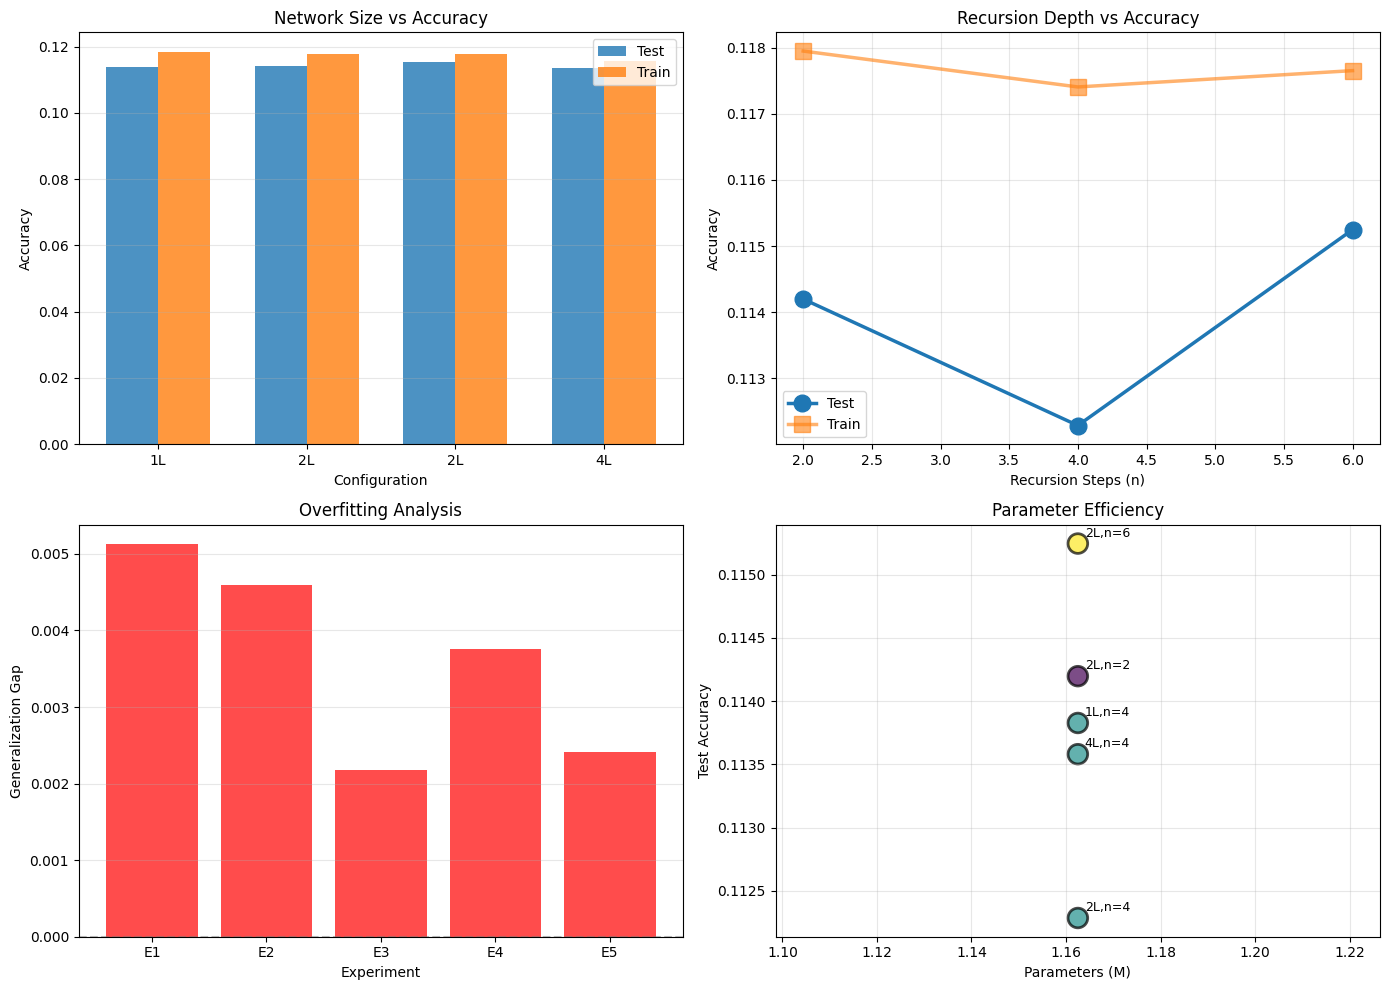


✓ Visualization complete!


In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create DataFrame
df = pd.DataFrame([{k: v for k, v in r.items() if k != 'history'} for r in results])

print("\n" + "="*70)
print("EXPERIMENT RESULTS")
print("="*70)
print(df.to_string(index=False))
print("="*70)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Network size comparison
layer_mask = df['name'].str.contains('Layer')
layer_data = df[layer_mask].sort_values('layers')
if len(layer_data) > 0:
    x = np.arange(len(layer_data))
    width = 0.35
    axes[0, 0].bar(x - width/2, layer_data['test_acc'], width, label='Test', alpha=0.8)
    axes[0, 0].bar(x + width/2, layer_data['train_acc'], width, label='Train', alpha=0.8)
    axes[0, 0].set_xlabel('Configuration')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Network Size vs Accuracy')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([f"{int(l)}L" for l in layer_data['layers']], rotation=0)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Recursion depth comparison
n_data = df[df['layers'] == 2].sort_values('n_recursions')
if len(n_data) > 0:
    axes[0, 1].plot(n_data['n_recursions'], n_data['test_acc'],
                    marker='o', linewidth=2.5, markersize=12, label='Test')
    axes[0, 1].plot(n_data['n_recursions'], n_data['train_acc'],
                    marker='s', linewidth=2.5, markersize=12, alpha=0.6, label='Train')
    axes[0, 1].set_xlabel('Recursion Steps (n)')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Recursion Depth vs Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Generalization gap
df['gen_gap'] = df['train_acc'] - df['test_acc']
axes[1, 0].bar(range(len(df)), df['gen_gap'], alpha=0.7, color='red')
axes[1, 0].set_xlabel('Experiment')
axes[1, 0].set_ylabel('Generalization Gap')
axes[1, 0].set_title('Overfitting Analysis')
axes[1, 0].set_xticks(range(len(df)))
axes[1, 0].set_xticklabels([f"E{i+1}" for i in range(len(df))], rotation=0)
axes[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Parameter efficiency
axes[1, 1].scatter(df['params_M'], df['test_acc'], s=200, alpha=0.7,
                   c=df['n_recursions'], cmap='viridis', edgecolors='black', linewidth=2)
for idx, row in df.iterrows():
    axes[1, 1].annotate(f"{int(row['layers'])}L,n={int(row['n_recursions'])}",
                        (row['params_M'], row['test_acc']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1, 1].set_xlabel('Parameters (M)')
axes[1, 1].set_ylabel('Test Accuracy')
axes[1, 1].set_title('Parameter Efficiency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('trm_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization complete!")

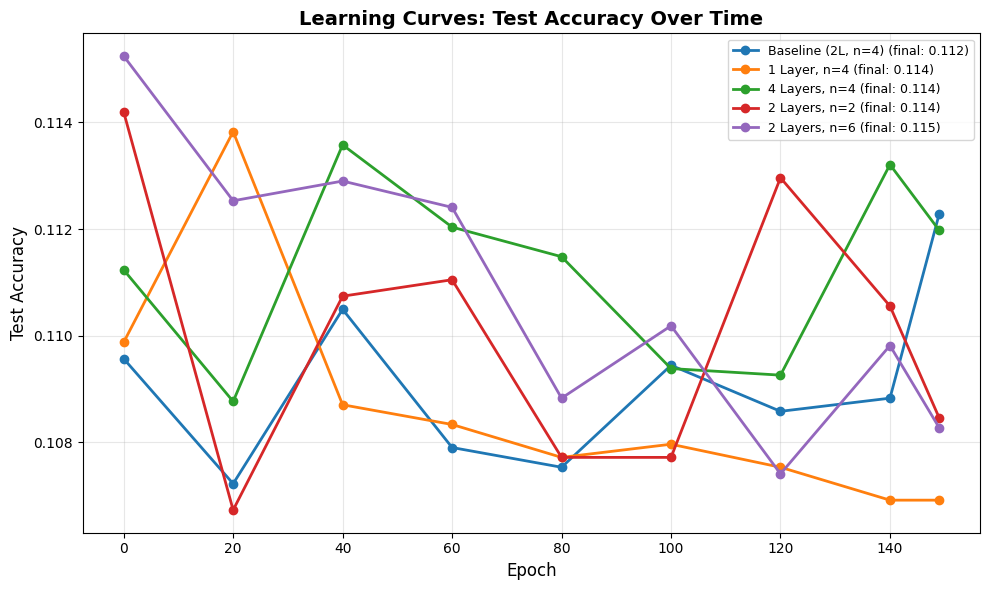

✓ Learning curves saved


In [9]:
# Plot training curves for key experiments
fig, ax = plt.subplots(figsize=(10, 6))

for result in results:
    history = result['history']
    label = f"{result['name']} (final: {result['test_acc']:.3f})"
    ax.plot(history['epoch'], history['test_acc'], marker='o',
            label=label, linewidth=2, markersize=6)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Learning Curves: Test Accuracy Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Learning curves saved")

In [10]:
from google.colab import files
import json

# Save results as CSV
df.to_csv('experiment_results.csv', index=False)

# Save detailed results as JSON
with open('detailed_results.json', 'w') as f:
    json.dump(results, f, indent=2, default=str)

# Download files
print("\nDownloading results...")
files.download('trm_results.png')
files.download('learning_curves.png')
files.download('experiment_results.csv')
files.download('detailed_results.json')

print("\n✓ All files downloaded!")
print("\nYou now have:")
print("  - trm_results.png (main figure)")
print("  - learning_curves.png (training dynamics)")
print("  - experiment_results.csv (summary table)")
print("  - detailed_results.json (full data)")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ All files downloaded!

You now have:
  - trm_results.png (main figure)
  - learning_curves.png (training dynamics)
  - experiment_results.csv (summary table)
  - detailed_results.json (full data)
